In [13]:
!pip install qiskit-machine-learning qiskit-ibm-runtime qiskit-algorithms tensorflow scikit-learn pandas matplotlib seaborn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 131.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires dill<0.3.9,>=0.3.0, but you have dill 0.4.0 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.1.3 which is incompatible.


In [2]:
# !pip install --upgrade --force-reinstall qiskit qiskit-aer qiskit-machine-learning
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 137.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 121.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 103.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 5.4 MB/s eta 0:00:00


In [14]:
# Imports & Setup
import qiskit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

# Quantum Libraries
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms import VQC
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, errors
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap, EfficientSU2
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC, NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import COBYLA

# Aer primitives (preferred). If unavailable, fall back to default primitives.
try:
    from qiskit_aer.primitives import Sampler as AerSampler
    AER_PRIMITIVES_OK = True
except Exception:
    from qiskit.primitives import Sampler as AerSampler
    AER_PRIMITIVES_OK = False

# ML Libraries
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
import random



print('All imports successful')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

All imports successful


In [15]:
# Privacy Guard
class PrivacyGuard:
    @staticmethod
    def assert_local(data, client_id):
        print(f"[PRIVACY] Client {client_id} uses {len(data)} samples. (Hash:{hash(str(data)[:40])})")

In [38]:
# Feature Maps
def custom_ansatz(num_qubits, depth=3):
    qc = QuantumCircuit(num_qubits)
    theta = ParameterVector('θ', num_qubits * depth)
    for d in range(depth):
        for i in range(num_qubits):
            qc.ry(theta[i + d*num_qubits], i)
        for i in range(num_qubits-1):
            qc.cz(i, i+1)
        if num_qubits > 2:
            qc.cz(num_qubits-1, 0)
    return qc

def linear_feature_map(num_qubits):
    qc = QuantumCircuit(num_qubits)
    x = ParameterVector('x', num_qubits)
    for i in range(num_qubits):
        qc.rx(x[i]*np.pi, i)
    return qc

def load_cifar_subset(num_samples=300, num_features=8):
    (X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
    X = np.vstack([X_train.reshape(X_train.shape[0], -1), X_test.reshape(X_test.shape[0], -1)])
    y = np.concatenate([y_train.ravel(), y_test.ravel()])
    idx = np.random.choice(len(X), num_samples, replace=False)
    X_small = X[idx] / 255.0
    y_small = y[idx]
    X_small = X_small[:, :num_features]
    X_tr, X_te, y_tr, y_te = train_test_split(X_small, y_small, test_size=0.2, random_state=42)
    return X_tr, X_te, y_tr, y_te

def run_classical(X_train, y_train, X_test, y_test):
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    return acc, f1, cm

def get_simple_noise_model():
    noise_model = NoiseModel()
    dep_err = errors.depolarizing_error(0.05, 1)
    noise_model.add_all_qubit_quantum_error(dep_err, ['ry','rx','cz'])
    return noise_model

In [39]:
class FederatedClient:
    def __init__(self, client_id, X, y):
        PrivacyGuard.assert_local(X, client_id)
        self.client_id = client_id
        self.X = X
        self.y = y
        self.history = []

    def local_train(self, vqc):
        """
        Local training: reuse the shared VQC instance.
        No get/set_weights, because this VQC version does not expose them.
        """
        vqc.fit(self.X, self.y)
        acc = vqc.score(self.X, self.y)
        print(f"[Client {self.client_id}] Local accuracy: {acc:.3f}")
        self.history.append(acc)
        return None, acc

    def get_data_hash(self):
        return hash(str(self.X)[:40] + str(self.y)[:40])

class FederatedServer:
    def __init__(self, num_clients, simulate_noise=False):
        self.num_clients = num_clients
        self.global_accs = []
        self.errors = []
        self.simulate_noise = simulate_noise  # kept only for API compatibility

    def fedavg(self, weights_list):
        """
        Placeholder FedAvg: since we are not using explicit weights,
        this is not used. Kept for completeness.
        """
        return None

    def execute_round(self, clients, vqc, X_test, y_test, noise_model=None, backend=None):
        """
        Simple federated round:
        - Each client trains sequentially on the shared VQC.
        - We record each client's local accuracy.
        - After all clients train, we evaluate the global model.
        """
        all_client_accs = []

        for client in clients:
            try:
                _, acc = client.local_train(vqc)
                all_client_accs.append(acc)
            except Exception as e:
                self.errors.append(str(e))
                all_client_accs.append(0.0)

        # Evaluate global model on test set
        try:
            global_acc = vqc.score(X_test, y_test)
        except Exception as e:
            self.errors.append("Global evaluation error: " + str(e))
            global_acc = 0.0

        self.global_accs.append(global_acc)
        print(f"[SERVER] Global test accuracy: {global_acc:.4f}")
        return all_client_accs, global_acc

In [43]:
def run_experiment(ds_name, X_train, y_train, X_test, y_test, num_qubits,
                   ansatz_type="custom", simulate_noise=False):
    print(f"\n====================== {ds_name} | Ansatz: {ansatz_type} ======================")

    # 1. Classical baseline
    cl_acc, cl_f1, cl_cm = run_classical(X_train, y_train, X_test, y_test)
    print(f"[CLASSICAL] Accuracy={cl_acc:.4f}, F1={cl_f1:.4f}")
    print("Confusion matrix (classical):\n", cl_cm)

    # 2. Quantum centralized baseline
    if ansatz_type == "custom":
        fm = linear_feature_map(num_qubits)
        # slightly stronger settings for IRIS
        if ds_name.upper() == "IRIS":
            qc = custom_ansatz(num_qubits, depth=3)
            opt = COBYLA(maxiter=40)
        else:
            qc = custom_ansatz(num_qubits, depth=2)
            opt = COBYLA(maxiter=30)
    else:
        fm = linear_feature_map(num_qubits)
        qc = linear_feature_map(num_qubits)
        opt = COBYLA(maxiter=30)

    vqc = VQC(
        num_qubits=num_qubits,
        feature_map=fm,
        ansatz=qc,
        loss='cross_entropy',
        optimizer=opt
    )
    vqc.fit(X_train, y_train)
    q_acc = vqc.score(X_test, y_test)   # <-- ensure q_acc is defined
    print(f"[QUANTUM CENTRALIZED] Accuracy={q_acc:.4f}")

    # 3. Federated setup (3 clients)
    splits = np.array_split(np.arange(X_train.shape[0]), 3)
    clients = [FederatedClient(cid, X_train[idx], y_train[idx])
               for cid, idx in enumerate(splits)]

    # 4. Server (no noise)
    server = FederatedServer(num_clients=3, simulate_noise=False)
    noise_model = None
    backend = None

    # 5. Federated rounds
    nrounds = 10
    history_global = []
    history_clients = []

    for round_num in range(1, nrounds + 1):
        print(f"\n== {ds_name} Round {round_num} ==")
        cl_accs, g_acc = server.execute_round(
            clients, vqc, X_test, y_test,
            noise_model=noise_model,
            backend=backend
        )
        history_clients.append(cl_accs)
        history_global.append(g_acc)

    # 6. Save CSV
    results_df = pd.DataFrame({
        'round': range(1, nrounds + 1),
        'global_model_acc': history_global,
        'client0_acc': [x[0] for x in history_clients],
        'client1_acc': [x[1] for x in history_clients],
        'client2_acc': [x[2] for x in history_clients]
    })
    results_df.to_csv(f"{ds_name.lower()}_{ansatz_type}_results.csv", index=False)
    print(f"[EXPORT] CSV: {ds_name.lower()}_{ansatz_type}_results.csv")

    # 7. Plot and save PNG
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, nrounds + 1), history_global,
             label='Global Quantum Model', linewidth=3, marker='o')
    for c in range(3):
        plt.plot(range(1, nrounds + 1),
                 [accs[c] for accs in history_clients],
                 label=f'Client {c} Local', linestyle='--', marker='x')
    plt.axhline(cl_acc, color='gray', linestyle=':',
                label='Classical Baseline')
    plt.axhline(q_acc, color='orange', linestyle=':',
                label='Quantum Centralized')
    plt.title(f'Federated Quantum Learning ({ds_name} | {ansatz_type})',
              fontsize=14)
    plt.xlabel('Federated Communication Round')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    png_file = f"{ds_name.lower()}_{ansatz_type}_accuracy.png"
    plt.savefig(png_file, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"[EXPORT] PNG: {png_file}")

    # 8. Circuit diagram (optional)
    try:
        img_file = f"{ds_name.lower()}_{ansatz_type}_circuit.png"
        qc.draw('mpl').savefig(img_file)
        print(f"[EXPORT] Circuit diagram PNG: {img_file}")
    except Exception:
        print("[WARN] Circuit diagram save failed (need matplotlib inline backend)")

    # 9. Privacy + error logs
    print("\nPRIVACY HASHES:")
    for cid, client in enumerate(clients):
        print(f"Client {cid} data hash:", client.get_data_hash())
    print("Federated server errors:", server.errors)

    print("[SUMMARY] Final: Classical: {:.3f}, Quantum: {:.3f}, Quantum Fed: {:.3f}"
          .format(cl_acc, q_acc, history_global[-1]))
    print("[Confusion Matrix] Final:\n", confusion_matrix(y_test, vqc.predict(X_test)))

    return results_df

Data Summary: IRIS: Train=(120, 4) Test=(30, 4) Qubits=4 

====================== IRIS | Ansatz: custom ======================
[CLASSICAL] Accuracy=0.9667, F1=0.9659
Confusion matrix (classical):
 [[10  0  0]
 [ 0  8  1]
 [ 0  0 11]]
[QUANTUM CENTRALIZED] Accuracy=0.5333
[PRIVACY] Client 0 uses 40 samples. (Hash:3478033085265076512)
[PRIVACY] Client 1 uses 40 samples. (Hash:-2313372592572895811)
[PRIVACY] Client 2 uses 40 samples. (Hash:3476831894873691349)

== IRIS Round 1 ==
[Client 0] Local accuracy: 0.600
[Client 1] Local accuracy: 0.475
[Client 2] Local accuracy: 0.475
[SERVER] Global test accuracy: 0.5333

== IRIS Round 2 ==
[Client 0] Local accuracy: 0.600
[Client 1] Local accuracy: 0.475
[Client 2] Local accuracy: 0.475
[SERVER] Global test accuracy: 0.5333

== IRIS Round 3 ==
[Client 0] Local accuracy: 0.600
[Client 1] Local accuracy: 0.475
[Client 2] Local accuracy: 0.475
[SERVER] Global test accuracy: 0.5333

== IRIS Round 4 ==
[Client 0] Local accuracy: 0.600
[Client 1] Loc

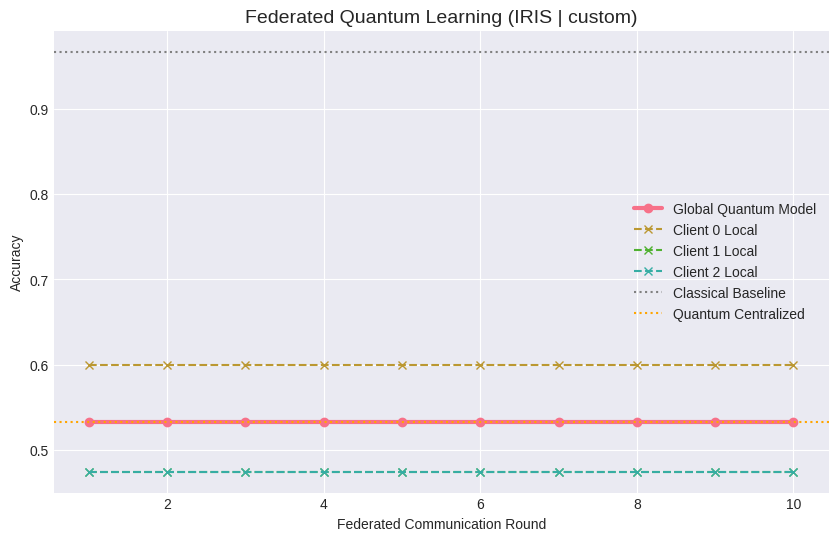

[EXPORT] PNG: iris_custom_accuracy.png
[WARN] Circuit diagram save failed (need matplotlib inline backend)

PRIVACY HASHES:
Client 0 data hash: 967712282427373120
Client 1 data hash: 4313268896489079768
Client 2 data hash: -3092709314415167119
Federated server errors: []
[SUMMARY] Final: Classical: 0.967, Quantum: 0.533, Quantum Fed: 0.533
[Confusion Matrix] Final:
 [[10  0  0]
 [ 3  6  0]
 [ 0 11  0]]
Data Summary: MNIST: Train=(240, 8) Test=(60, 8) Qubits=8 

====================== MNIST | Ansatz: custom ======================
[CLASSICAL] Accuracy=0.6333, F1=0.3878
Confusion matrix (classical):
 [[ 0 22]
 [ 0 38]]
[QUANTUM CENTRALIZED] Accuracy=0.3667
[PRIVACY] Client 0 uses 80 samples. (Hash:-6637907535333572477)
[PRIVACY] Client 1 uses 80 samples. (Hash:-6637907535333572477)
[PRIVACY] Client 2 uses 80 samples. (Hash:-6637907535333572477)

== MNIST Round 1 ==
[Client 0] Local accuracy: 0.487
[Client 1] Local accuracy: 0.537
[Client 2] Local accuracy: 0.463
[SERVER] Global test accur

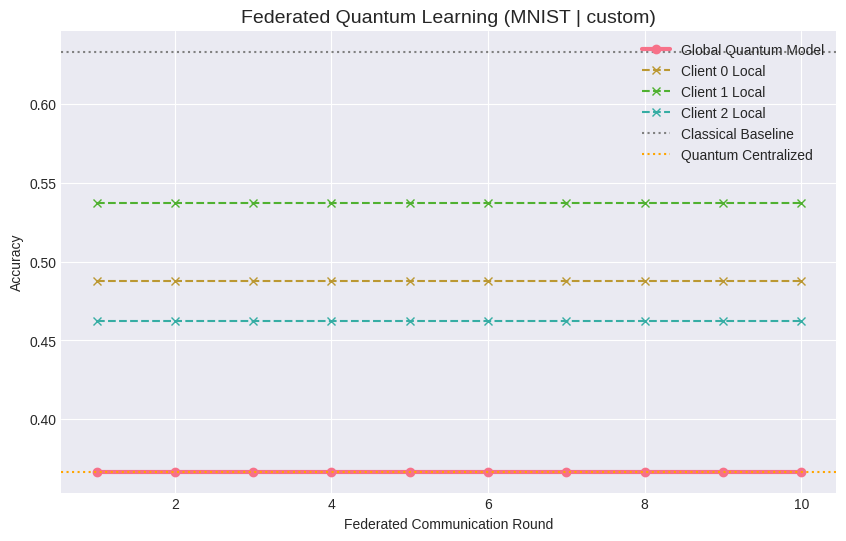

[EXPORT] PNG: mnist_custom_accuracy.png
[WARN] Circuit diagram save failed (need matplotlib inline backend)

PRIVACY HASHES:
Client 0 data hash: 8844648233624624435
Client 1 data hash: 1823862307719908195
Client 2 data hash: -6035339979231510835
Federated server errors: []
[SUMMARY] Final: Classical: 0.633, Quantum: 0.367, Quantum Fed: 0.367
[Confusion Matrix] Final:
 [[22  0]
 [38  0]]
Data Summary: CIFAR10: Train=(160, 8) Test=(40, 8) Qubits=8 

====================== CIFAR10 | Ansatz: custom ======================
[CLASSICAL] Accuracy=0.0500, F1=0.0220
Confusion matrix (classical):
 [[1 0 0 0 0 2 0 0 0 0]
 [1 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 2 2 0 0 0 0]
 [5 0 0 0 1 1 0 0 0 0]
 [1 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 5 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0]
 [1 0 0 0 1 1 0 0 0 0]
 [2 0 0 0 2 0 0 0 0 0]
 [6 0 0 0 0 0 0 0 0 0]]
[QUANTUM CENTRALIZED] Accuracy=0.1000
[PRIVACY] Client 0 uses 54 samples. (Hash:4230645960378598456)
[PRIVACY] Client 1 uses 53 samples. (Hash:-8167041242404466106)
[PRIVACY] C

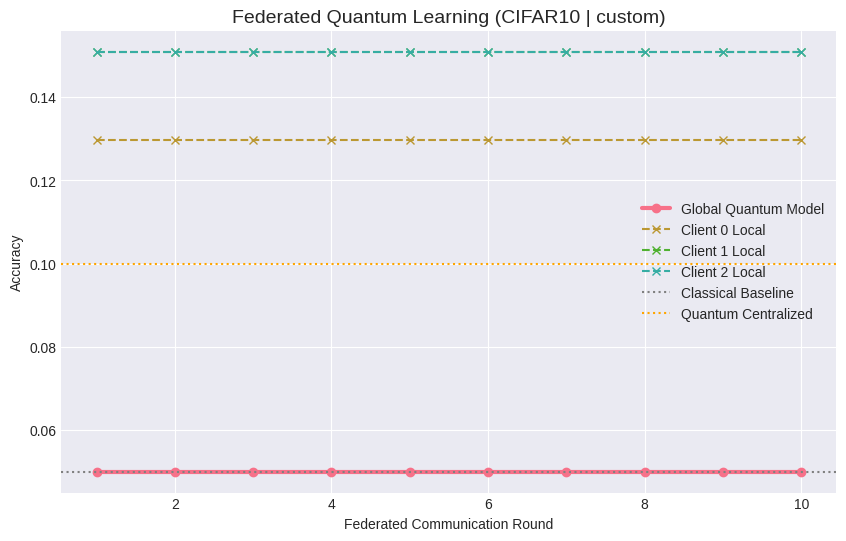

[EXPORT] PNG: cifar10_custom_accuracy.png
[WARN] Circuit diagram save failed (need matplotlib inline backend)

PRIVACY HASHES:
Client 0 data hash: -2165185636977181662
Client 1 data hash: -2856730902151425120
Client 2 data hash: -290458399951138908
Federated server errors: []
[SUMMARY] Final: Classical: 0.050, Quantum: 0.100, Quantum Fed: 0.050
[Confusion Matrix] Final:
 [[1 2 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [2 3 0 0 0 0 0 0 0 0]
 [5 2 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [1 5 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0]
 [1 2 0 0 0 0 0 0 0 0]
 [2 2 0 0 0 0 0 0 0 0]
 [5 1 0 0 0 0 0 0 0 0]]


In [44]:
# Multi-dataset autoRunner
datasets = {}
iris = load_iris()
scaler = MinMaxScaler()
X_iris = scaler.fit_transform(iris.data)
y_iris = iris.target
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris, y_iris, test_size=0.2, random_state=42)
datasets['IRIS'] = (X_train_iris, y_train_iris, X_test_iris, y_test_iris, X_train_iris.shape[1])

# MNIST – binary subset (easier for small VQC)
(X_train_m, y_train_m), (X_test_m, y_test_m) = keras.datasets.mnist.load_data()
X_all = np.vstack([X_train_m.reshape(X_train_m.shape[0], -1),
                   X_test_m.reshape(X_test_m.shape[0], -1)])
y_all = np.concatenate([y_train_m, y_test_m])

# Keep only digits 0 and 1 (change digits if you like)
mask = (y_all == 0) | (y_all == 1)
X_all = X_all[mask]
y_all = y_all[mask]

# Small random subset
np.random.seed(42)
idx = np.random.choice(len(X_all), 300, replace=False)
X_m_sub = X_all[idx] / 255.0
y_m_sub = y_all[idx]

# Use first 8 features for quantum circuit
X_m_sub = X_m_sub[:, :8]

X_train_msub, X_test_msub, y_train_msub, y_test_msub = train_test_split(
    X_m_sub, y_m_sub, test_size=0.2, random_state=42
)
datasets['MNIST'] = (X_train_msub, y_train_msub, X_test_msub, y_test_msub, X_train_msub.shape[1])


X_train_cif, X_test_cif, y_train_cif, y_test_cif = load_cifar_subset(num_samples=200, num_features=8)
datasets['CIFAR10'] = (X_train_cif, y_train_cif, X_test_cif, y_test_cif, X_train_cif.shape[1])

for ds_name in datasets:
    Xtr, ytr, Xte, yte, nqubits = datasets[ds_name]
    print(f"Data Summary: {ds_name}: Train={Xtr.shape} Test={Xte.shape} Qubits={nqubits} ")
    run_experiment(ds_name, Xtr, ytr, Xte, yte, nqubits, ansatz_type='custom', simulate_noise=False)